In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
np.random.seed(42)


# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tracking"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
rDet         = np.array([0.5, 1.0, 1.5, 2, 2.5,3.0])
nModPerLayer = np.array([14,   28,  42, 56, 70, 84])

xDet = np.linspace(-3, 3, 5000)
yDet = np.sqrt(0.5**2-xDet**2)

/Users/johnda/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


# Helper Functions

In [3]:
# Note there are 2 different phis used:
#   - phi_circle (the angle of the center of the circle in r-phi plane)
#   - phi_track (the direction of the particle that made the track) 
#
#  For positive tracks: phi_circle = phi_track - pi/2
#  For negative tracks: phi_circle = phi_track + pi/2
from TrackHelper import getPhiCircle
from TrackHelper import drawTrack


# Now Detector Classes

In [4]:
from layer import layer
from detectorGeo import detectorGeo

# Draw Modules in One Layer

In [5]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 0.75
ax.set_xlim((-1*zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

layer0 = layer()
layer0.initSimple(0,rDet[0],nModPerLayer[0])
layer0.drawLayer(ax, detailed=True)

# Now do modules in all layers

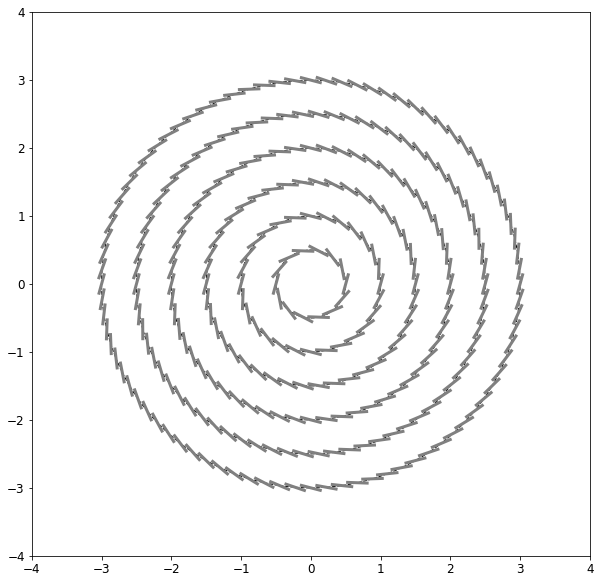

In [6]:

fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 4
ax.set_xlim((-1*zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

detGeo = detectorGeo()
detGeo.initSimple(rDet,nModPerLayer)
detGeo.drawDetector(ax,detailed=True)
    

# OK now get hit positions from Truth tracks

In [7]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 2

ax.set_xlim((-1*zoom, zoom))
ax.set_ylim((-1*zoom, zoom))


trk_rc  = 5
trk_phi = 0*np.pi/400
trk_q   = +1

detGeo.drawDetector(ax,True)
drawTrack(trk_rc,trk_phi,trk_q)

ps_hitXs, ps_hitYs, modulesHit, hits = detGeo.getHits(trk_rc,trk_phi,trk_q)
print(modulesHit)
detGeo.drawDetectorModules(modulesHit,False)
plt.plot(ps_hitXs,ps_hitYs,'ro')


for h in hits:
    plt.plot(h[1],h[2],'bo')




[(0, 0, 0), (0, 1, 0), (0, 1, 27), (0, 2, 41), (0, 3, 54), (0, 4, 67), (0, 5, 80)]


Working!  the red points are the "pseudo" hits defined as the hit position in the fully symetric detector
The blue points are the real hits in the actual detector

# OK, now lets try to plot the hits of a bunch of tracks

Generating the tracks

In [8]:
np.random.seed(42)

# Kaggle formats
eventParticles = []
eventTruth = []
eventHits = []

# For plotting 
solutions = []

nTrk = 50
hitID = 0

for trkI in range(nTrk):
    ptInv = np.random.uniform(0.01,0.5,1)[0]
    phi   = np.random.uniform(0.0,2*np.pi,1)[0]
    q     = 2*np.random.randint(0,2,1)[0]-1
    pt = 1./ptInv

    eventParticles.append((trkI,pt,phi,q,6))

    #xHits, yHits = getHits(pt,phi,q,rDet)
    ps_hitXs, ps_hitYs, modulesHit, hits = detGeo.getHits(pt,phi,q)
    ps_hitZs = None
    
    solutions.append([hits,pt,phi,q,ps_hitXs,ps_hitYs,ps_hitZs])
    #truthHits+=hits

    for hitsInfo in hits:
        hitX   = hitsInfo[1]        
        hitY   = hitsInfo[2]
        hitZ   = None
        eventTruth.append((hitID,trkI,hitX,hitY,hitZ,1.0))
        eventHits .append((hitID,hitX,hitY,hitZ,hitsInfo[0][0],hitsInfo[0][1],hitsInfo[0][2]))        
        hitID += 1


/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:133: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:134: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:135: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:136: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))


Making reconstructed hits from the truth hits (Can add noise hits here later)

In [9]:
recHits = np.array(eventHits)

np.random.seed(42)
shuffle_index = np.random.permutation(len(recHits))
recHits = recHits[shuffle_index]
recHits[0:10]

array([[222, 1.4560426319579243, -2.060176153359556, None, 0, 4, 59],
       [42, 2.031656127987177, -1.4620830489149932, None, 0, 4, 63],
       [291, -1.7042327375325137, -1.8455343300097602, None, 0, 4, 44],
       [300, -0.42338508751660664, 0.24843188141245487, None, 0, 0, 6],
       [56, 1.944809891103257, 0.3101864624885806, None, 0, 3, 2],
       [335, -0.5880272010064416, -2.420552699165264, None, 0, 4, 50],
       [15, 0.9245480256126819, 0.30926489370635135, None, 0, 1, 2],
       [57, 2.456041997571464, 0.4005312223871691, None, 0, 4, 2],
       [245, -0.08651926755441902, -0.5005400617684002, None, 0, 0, 10],
       [124, -0.40666554150511225, 0.3495022891019143, None, 0, 0, 5]],
      dtype=object)

Plot Reconstructed Hits

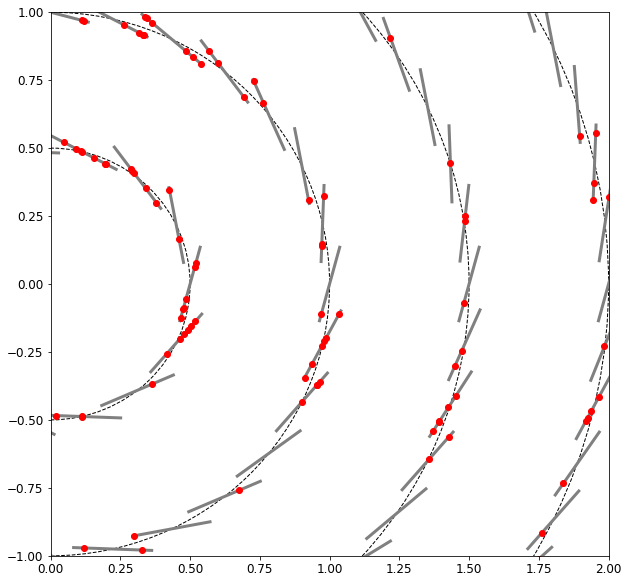

In [10]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 1

ax.set_xlim((-1*zoom+1, zoom+1))
ax.set_ylim((-1*zoom, zoom))
detGeo.drawDetector(ax,True)

plt.plot(recHits[:,1],recHits[:,2],'ro')

# Plot Solutions

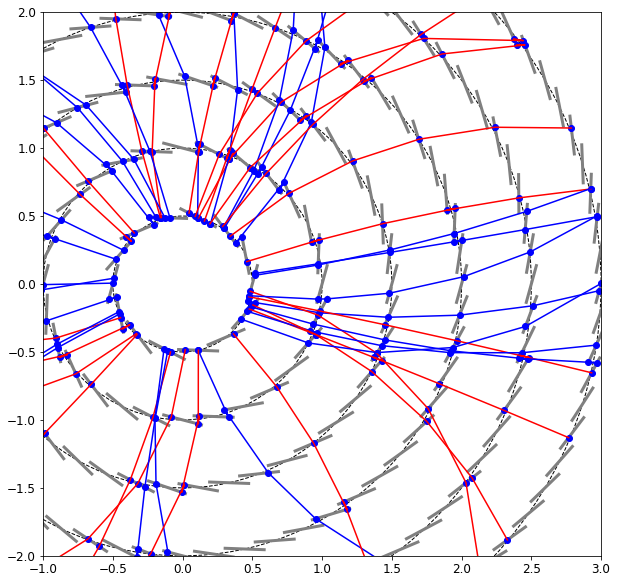

In [11]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 2

ax.set_xlim((-1*zoom+1, zoom+1))
ax.set_ylim((-1*zoom, zoom))
detGeo.drawDetector(ax,True)
plt.plot(recHits[:,1],recHits[:,2],'bo')

for s in solutions:

    thisHits = s[0]
    thisPt   = s[1]
    thisPhi  = s[2]    
    thisQ    = s[3]        

    hitXs = []
    hitYs = []    
    for h in thisHits:
        hitXs.append(h[1])
        hitYs.append(h[2])
    
    color = "b" if (thisQ < 0) else "r"
    plt.plot(hitXs,hitYs,color)

# Test "Offline"  algorithm (ie: Hough transform) works

First try one track

### Implement the Hough transform

In [12]:
# given global posision and phi range, return consistent 1/rC
def getHT(hX, hY, phi):
    R2 = hX**2 + hY**2
    phi_circle = getPhiCircle(phi,1)

    f = 2/R2*(hX*np.cos(phi_circle)+hY*np.sin(phi_circle))
    return f

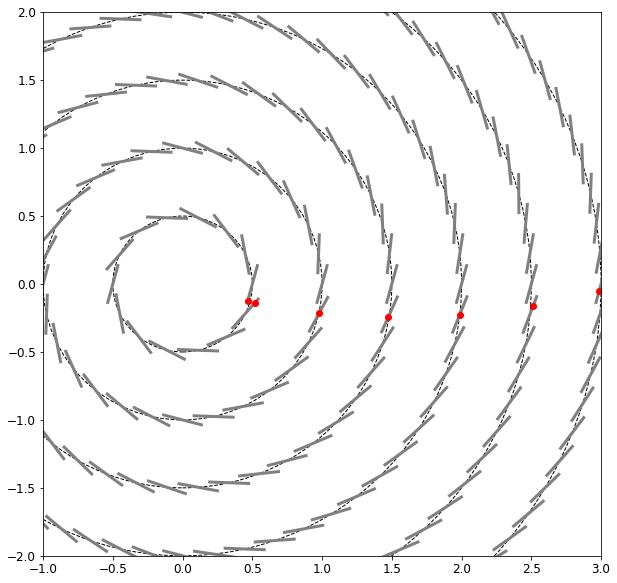

In [13]:
sTest = solutions[0]
#testHits = np.array(sTest[0])

truthHits_raw = []
for tH in sTest[0]:
    truthHits_raw.append( (tH[1],tH[2]) )

#print(truthHits_raw)
tHits = np.array(truthHits_raw)

fig, ax = plt.subplots(1, figsize=(10,10))

zoom = 2

ax.set_xlim((-1*zoom+1, zoom+1))
ax.set_ylim((-1*zoom, zoom))
detGeo.drawDetector(ax,True)


plt.plot(tHits[:,0],tHits[:,1],'ro')

In [14]:
plt.figure(1, figsize=(10, 10))
plt.title("Positive Track Solutions")
plt.axis([0, 2*np.pi, -0.5,0.5])  

soln = solutions[0]

truePhi = soln[2]
trueQ   = soln[3]
trueRc  = soln[1]
print("Truth Track, 1/Rc / phi / q",1./trueRc,truePhi,trueQ)


for hitItr in range(len(soln[0])):

    hitX = soln[0][hitItr][1]
    hitY = soln[0][hitItr][2]

    hitPhi = np.arctan2(hitY, hitX)   
    
    # Convert 0-2Pi
    if hitPhi<0: hitPhi += 2*np.pi
    
    # Only consider plasiblel track (eg: from the orgin)
    phiXRange = np.linspace(hitPhi-np.pi/2, hitPhi+np.pi/2, 500)

    
    f = getHT(hitX, hitY,  phiXRange)
    plt.plot(phiXRange,f,"k")

plt.plot(truePhi,trueQ*1/trueRc,"ro")    

plt.show()

Truth Track, 1/Rc / phi / q 0.1935246582352076 5.9735141613602165 -1


Math still works!

## Try it on a few tracks

Truth Track, 1/Rc / phi / q 0.1935246582352076 5.9735141613602165 -1
Truth Track, 1/Rc / phi / q 0.392048590133657 3.7501201429971824 1
Truth Track, 1/Rc / phi / q 0.08643731496473929 0.3649500985631483 1
Truth Track, 1/Rc / phi / q 0.1735172194581207 0.8976586912506395 -1
Truth Track, 1/Rc / phi / q 0.020086402204943198 6.094123332392967 1


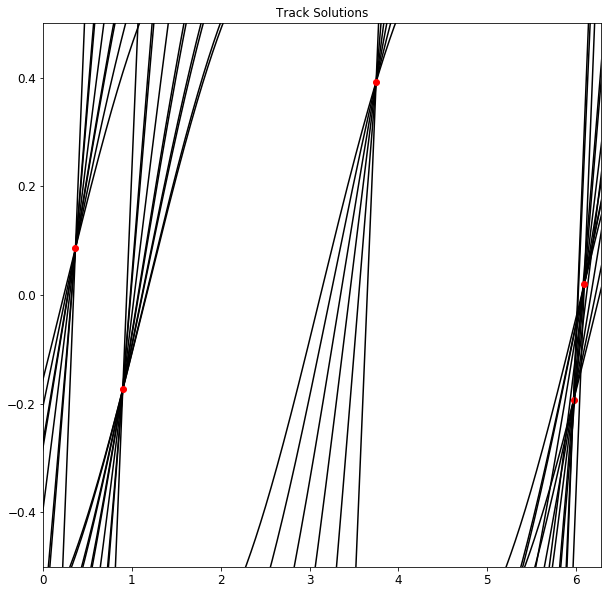

In [15]:
nTracks = 5 


plt.figure(1, figsize=(10, 10))
plt.title("Track Solutions")
plt.axis([0, 2*np.pi, -0.5,0.5])  

# Loop on Tracks
for solnItr in range(nTracks):
                
    soln = solutions[solnItr]
    truePhi = soln[2]
    trueQ   = soln[3]
    trueRc  = soln[1]
    print("Truth Track, 1/Rc / phi / q",1./trueRc,truePhi,trueQ)

    # Loop on hits
    for hitItr in range(len(soln[0])):

        hitX = soln[0][hitItr][1]
        hitY = soln[0][hitItr][2]

        hitPhi = np.arctan2(hitY, hitX)   
    
        # Convert 0-2Pi
        if hitPhi<0: hitPhi += 2*np.pi
    
        # Only consider plasiblel track (eg: from the orgin)
        phiXRange = np.linspace(hitPhi-np.pi/2, hitPhi+np.pi/2, 500)


        
        f = getHT(hitX, hitY,  phiXRange)
        plt.plot(phiXRange,f,"k")

    plt.plot(truePhi,trueQ*1/trueRc,"ro")   
        

plt.show()

# Try the HT track finder

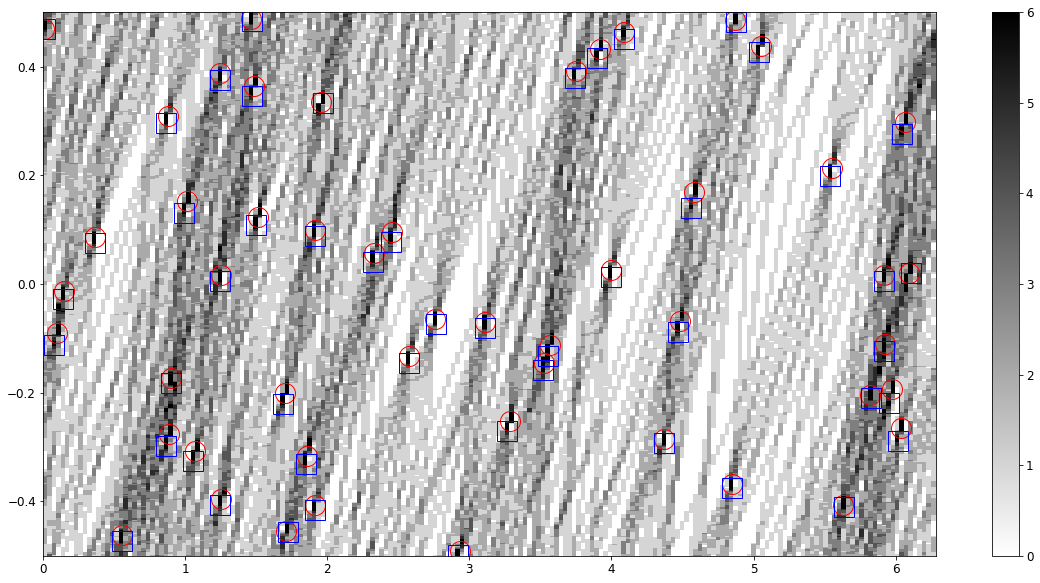

In [16]:
from HTTrackFinder import HTTrackFinding

def getHTForTrackFinding(hitR,hitPhi,phi):
    #Convert 0-2Pi
    if hitPhi<0: hitPhi += 2*np.pi
    phi_circle = phi - np.pi/2
    return 2/hitR*(np.cos(hitPhi-phi_circle))

testMod = HTTrackFinding(0,2*np.pi,200,-0.5,0.5,400,getHTFunction=getHTForTrackFinding)

fig, ax = plt.subplots(1, figsize=(20,10))

#
# Loop on rec hits
# 
for hitInfo in recHits:

    hitID  = hitInfo[0]
    hitX   = hitInfo[1]    
    hitY   = hitInfo[2]
    
    hitVolID = int(hitInfo[4])
    hitLayID = int(hitInfo[5])    
    globalLayID = detGeo.getGlobalLayerID(hitVolID,hitLayID)
    
    # convert to r and phi
    hitR = np.sqrt(hitX**2 + hitY**2)
    hitPhi = np.arctan2(hitY, hitX)
    if hitPhi<0: hitPhi += 2*np.pi
    
    testMod.addHit(globalLayID, hitID, hitR, hitPhi)
    
#    
# Plot Truth
#
for part in eventParticles:
    truePhi = part[2]
    trueQ   = part[3]
    trueRc  = part[1]    
    #eventParticles.append((trkI,pt,phi,q,6))

    ax.plot(truePhi,trueQ*1/trueRc,
            "o",markersize=20,markeredgewidth=1,markeredgecolor='r',markerfacecolor='None')

X, Y = np.meshgrid(testMod.xBins, testMod.yBins)
cmap = plt.get_cmap('binary')

testMod.combineLayerMaps()

#
#  Tracks
#
plt.figure(1)

ax.set_xlim(0,2*np.pi)
ax.set_ylim(-0.5,0.5)
H = np.array(testMod.HitDB.combinedHitsCounts).T
im = ax.pcolormesh(X, Y, H,cmap=cmap)
fig.colorbar(im, ax=ax)

recoTracks = testMod.findTracks()
for rT in recoTracks:
    recPhi  = rT[0]
    recQ    = rT[2]
    recCurv = rT[1]

    ax.plot(recPhi,recCurv,
            "s",markersize=20,markeredgewidth=1,markeredgecolor='b',markerfacecolor='None')
        
plt.show()



Red circles are the true tracks, Blue squares are the reco tracks 

Lets plot all the unused hits:

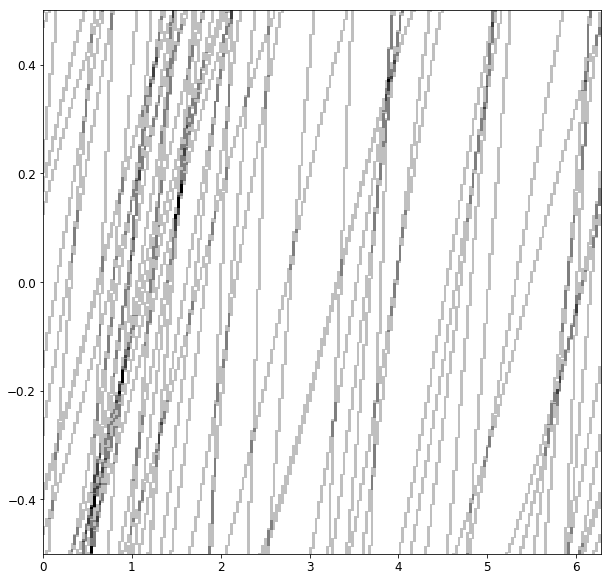

In [17]:
fig, ax_top = plt.subplots(1, figsize=(10,10))

plt.figure(1)
ax.set_xlim(0,2*np.pi)
ax.set_ylim(-0.5,0.5)
H = np.array(testMod.HitDB.combinedHitsCounts).T
im = ax_top.pcolormesh(X, Y, H,cmap=cmap)
fig.colorbar(im, ax=ax)


I think this b/c we not doing proper overlap handeling

Let try scoring.

In [18]:
solns = testMod.getSolutions()

truthArr = np.array(eventTruth)
truthArr = np.delete(truthArr, 2, axis=1)
truthArr = np.delete(truthArr, 2, axis=1)
truthArr = np.delete(truthArr, 2, axis=1)
import pandas as pd
truthDict = {
    "hit_id" : pd.Series(truthArr[:,0]),
    "particle_id" : pd.Series(truthArr[:,1]),    
    "weight" : pd.Series(truthArr[:,2]),
}

truth = pd.DataFrame(truthDict)


In [19]:

import score
score.score_event(truth,solns)

0.7507002801120448

Not bad

In [20]:
# Need to remove overlap ?
solns["hit_id"].value_counts()

356    1
116    1
118    1
119    1
120    1
121    1
122    1
123    1
124    1
126    1
127    1
128    1
129    1
130    1
131    1
132    1
133    1
117    1
115    1
90     1
114    1
93     1
94     1
96     1
98     1
99     1
100    1
101    1
104    1
105    1
      ..
253    1
254    1
255    1
256    1
257    1
258    1
259    1
261    1
262    1
263    1
264    1
248    1
247    1
246    1
237    1
227    1
228    1
231    1
234    1
235    1
236    1
238    1
245    1
239    1
240    1
241    1
242    1
243    1
244    1
0      1
Name: hit_id, Length: 299, dtype: int64